In [1]:
%matplotlib inline
import daft
import pymc
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import ggplot
import pandas as pd

COLORS = ["#348ABD", "#A60628", "#7A68A6"]


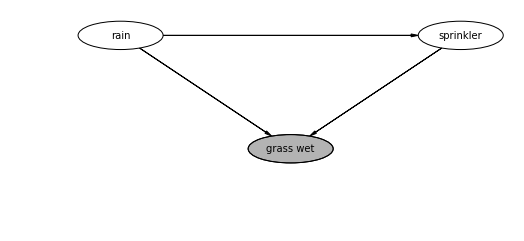

In [8]:
pgm = daft.PGM([9, 4], origin=[1, 0.5])
pgm.add_node(daft.Node('r', 'rain', 3, 4, aspect=3))
pgm.add_node(daft.Node('s', 'sprinkler', 9, 4, aspect=3))
pgm.add_node(daft.Node('w', 'grass wet', 6, 2, aspect=3, observed=True))
pgm.add_edge('r', 's')
pgm.add_edge('r', 'w')
pgm.add_edge('s', 'w')
pgm.render()

In [9]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/0/0e/SimpleBayesNet.svg')

In [14]:
# Initialization
observed_values = [1.]
rain = pymc.Bernoulli('rain', .2, value=np.ones(len(observed_values)))


p_sprinkler = pymc.Lambda('p_sprinkler', lambda rain=rain: np.where(rain, .01, .4))
# "Real" sprinkler varible
sprinkler = pymc.Bernoulli('sprinkler', p_sprinkler, value=np.ones(len(observed_values)))

p_grass_wet = pymc.Lambda('p_grass_wet', lambda sprinkler=sprinkler, rain=rain: np.where(sprinkler, np.where(rain, .99, .9), 
                                                                                         np.where(rain, .8, 0.2)))
grass_wet = pymc.Bernoulli('grass_wet', p_grass_wet, value=observed_values, observed=True)
model = pymc.Model([grass_wet, p_grass_wet, sprinkler, p_sprinkler, rain])


In [15]:
mcmc = pymc.MCMC(model)
mcmc.sample(10000, 2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.9 sec

In [16]:
trace_r = mcmc.trace('rain')[:]
trace_p_sprinkler = mcmc.trace('p_sprinkler')[:]
trace_sprinkler = mcmc.trace('sprinkler')[:]
trace_p_grass_wet = mcmc.trace('p_grass_wet')[:]

Plotting sprinkler_0
Plotting p_sprinkler_0
Plotting p_grass_wet_0
Plotting rain_0


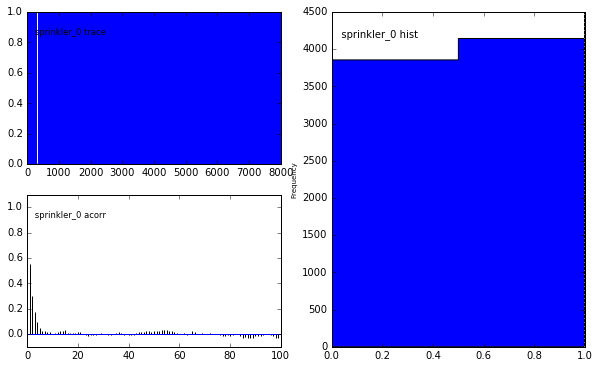

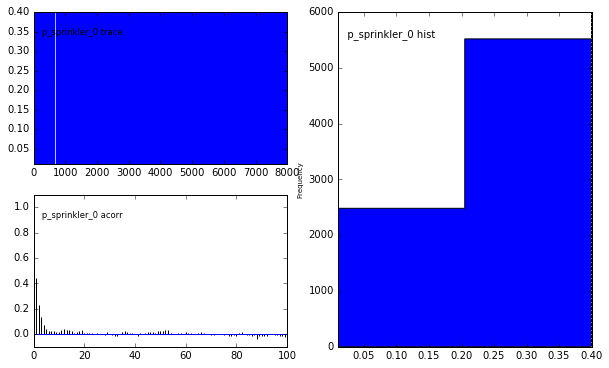

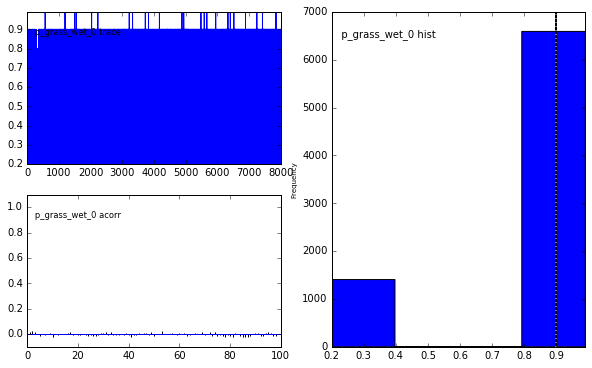

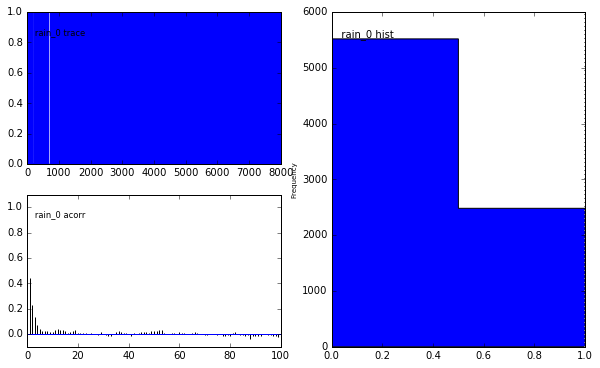

In [17]:
pymc.Matplot.plot(mcmc)

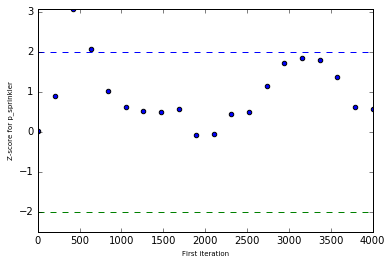

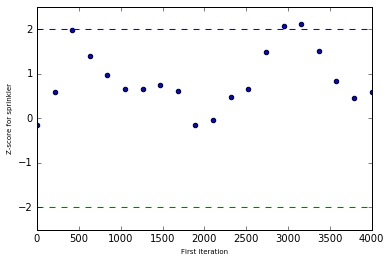

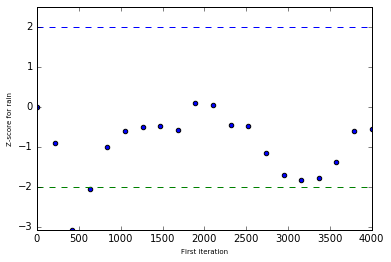

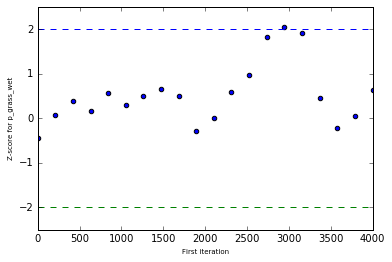

In [18]:
geweke = pymc.geweke(mcmc)
pymc.Matplot.geweke_plot(geweke)

In [19]:
dictionary = {
              'Rain': [1 if ii[0] else 0 for ii in trace_r.tolist() ],
              'Sprinkler': [1 if ii[0] else 0 for ii in trace_sprinkler.tolist() ],
              'Sprinkler Probability': [ii[0] for ii in trace_p_sprinkler.tolist()],
              'Grass Wet': [ii[0] for ii in trace_p_grass_wet.tolist()],
              }
df = pd.DataFrame(dictionary)
df.head()

,Grass Wet,Rain,Sprinkler,Sprinkler Probability
0,0.2,0,0,0.40
1,0.2,0,0,0.40
2,0.8,1,0,0.01
3,0.8,1,0,0.01
4,0.9,0,1,0.40


Given grass is wet, what is the probability that it was rained

In [22]:
p_rain_wet = float(df[(df['Rain'] == 1) & (df['Grass Wet'] > 0.5)].shape[0]) / df[df['Grass Wet'] > 0.5].shape[0] 
print(p_rain_wet)

0.376402790416


Given grass is wet, what is the probability that sprinkler was opened?

In [23]:
p_sprinkler_wet = float(df[df['Sprinkler'] == 1].shape[0]) / df[df['Grass Wet'] > 0.5].shape[0] 
print(p_sprinkler_wet)

0.628450106157


 when we look at the probability of that, it is not zero(albeit quite small).

In [24]:
p_not_sprinkler_rain_wet = float(df[(df['Sprinkler'] == 0) & (df['Rain'] == 0)].shape[0]) / df[df['Grass Wet'] > 0.5].shape[0] 
print(p_not_sprinkler_rain_wet)

0.21322414316
